# sampler-bug-report
this notebook documents diagnosing the nested sampling issue we've been having for a while, where the posterior returned by nested sampling with dynesty appears to be full of islands that are confidently skewed away from the truth values

In [1]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs_dynesty import WMSE
from pitchfuncs_dynesty import InversePCA
from pitchfuncs_dynesty import emulator
from pitchfuncs_dynesty import ns
from pitchfuncs_dynesty import ns_old
import pandas as pd
import scipy
import numpy as np
import corner
import time
from scipy import constants
from scipy import stats
import astropy.constants
import pickle
from matplotlib.pyplot import cm
import json
import matplotlib.pyplot as plt
import ultranest

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

# physical_devices = tf.config.list_physical_devices("GPU") 

# gpu0usage = tf.config.experimental.get_memory_info("GPU:0")["current"]

# print("Current GPU usage:\n"
#      + " - GPU0: " + str(gpu0usage) + "B\n")

2024-05-23 11:08:43.422846: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-23 11:08:43.422875: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-23 11:08:43.423728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-23 11:08:43.428517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 11:08:43.941192: W tensorflow/compiler/tf2

Start by choosing a hare and defining our priors - these will remain constant throughout so it makes sense to define them here:

## Import Hare:
This is a hare taken directly from the grid, so we don't have to worry about inconsistencies between simulations and observations here:

In [2]:
hare = pd.read_json("pickle jar/solar_hare2.json")

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
hare_inps = hare[inputs]

n_min = 6
n_max = 40

outputs = ['calc_effective_T', 'luminosity', 'star_feh'] + [f'nu_0_{i}' for i in range(n_min,n_max+1)]
hare_true = hare[outputs]

hare

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,star_feh,nu_0_4,...,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std,log_calc_effective_T_std
4098711,1,0.013508,0.24,1.9,4.605898,0.993668,0.904566,5650.91516,-0.0558,684.334509,...,0.727786,0.729035,0.730063,0.729626,0.730431,0.730403,0.729293,0.727165,0.724994,-0.345785


I use the n_min and n_max here to define the minimum and maximum radial orders we'll use - these will change throughout the notebook, but for now I'll leave them at n_min=6 and n_max=40. These are the full range of individual modes that are predicted by the neural network.

## Define priors:
Here we'll define our priors on the fundamental parameters. I'll leave these constant throughout for consistency.

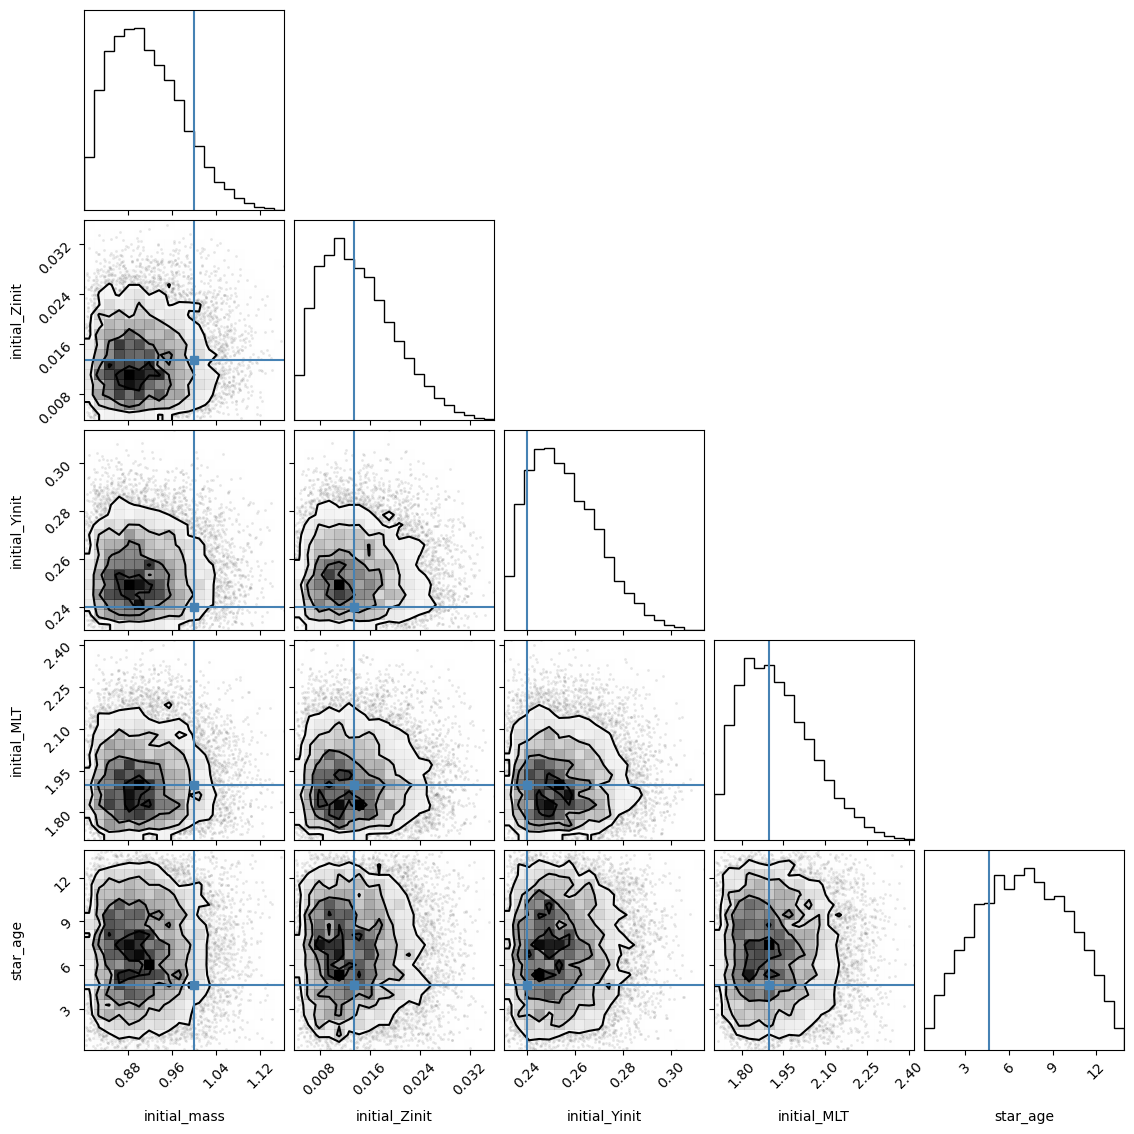

In [3]:
def grid_uniform_prior(pitchfork_ranges, header):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.uniform(loc=grid_min, scale=max(list(pitchfork_ranges["log_"+header].values()))-grid_min)

def grid_beta_prior(pitchfork_ranges, header,a=1,b=1):
    grid_min = min(list(pitchfork_ranges["log_"+header].values()))
    grid_max = max(list(pitchfork_ranges["log_"+header].values()))
    return scipy.stats.beta(loc=grid_min, scale=grid_max-grid_min, a=a, b=b)

def custom_uniform_prior(prior_min, prior_max):
    return scipy.stats.uniform(loc=prior_min, scale=prior_max-prior_min)

def custom_beta_prior(prior_min, prior_max, a=1, b=1):
    return scipy.stats.beta(loc=prior_min, scale=prior_max-prior_min, a=a, b=b)

mass_prior = custom_beta_prior(0.8, 1.2, a=2, b=5)

Zinit_prior = custom_beta_prior(0.0038, 0.04, a=2, b=5)

Yinit_prior = custom_beta_prior(0.23, 0.32, a=2, b=5)

MLT_prior = custom_beta_prior(1.7, 2.5, a=2, b=5)

age_prior = custom_beta_prior(0, 14, a=2, b=2)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});

## Import emulator:
Now we'll import our emulator. We start with the pcann network, which uses an inverse pca layer to reduce the 35 radial modes down to 14 principle components, before reprojection:


In [4]:
pitchfork_name = "nu6-40_elu_nonorm_feh"
pitchfork = emulator(pitchfork_name)

with open("pickle jar/" +pitchfork_name+ ".pkl", 'rb') as fp:
     pitchfork_info = pickle.load(fp)

pitchfork_ranges = pitchfork_info['parameter_ranges']

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-05-23 11:08:46.098203: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-23 11:08:46.098224: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-05-23 11:08:46.098229: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-05-23 11:08:46.098349: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-05-23 11:08:46.098371: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.171.4
2024-05-23 11:08:46.098375: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:241] kernel version seems to match DSO: 535.171.4


## Define likelihood:
No we'll define our likelihood function as a series of independent normal distributions centred on the observed values with width equal to the emulation uncertainty and the observational noise on each parameter:
$$\mathcal{L}(\textbf{y}|\theta) = \sum_{i}\log\mathcal{N}(y_{i}, \sqrt{\sigma_{y_{i},\textrm{obs}}^2 + \sigma_{y_{i},\textrm{NN}}^2}),$$
This *doesn't* take into account any potential covariance between predictions from the emulator. We'll come back to this later!

In [5]:
teff_unc = 70 #K
luminosity_unc = 0.04 #L\odot
surface_feh_unc = 0.1 #dex
frequency_unc = 0.5 #\muHz

obs_unc = np.array([teff_unc, luminosity_unc, surface_feh_unc]+[frequency_unc for i in range(n_min,n_max +1)])
obs_unc

array([7.e+01, 4.e-02, 1.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01,
       5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01, 5.e-01])

In [7]:
with open('pickle jar/emulator_unc.json') as json_file:
    emulator_unc_dict = json.load(json_file)

emulator_unc_dict['calc_effective_T'] = emulator_unc_dict.pop('effective_T')

emulator_unc = np.array([emulator_unc_dict[output]['mad'] for output in outputs])
emulator_unc

array([2.12793062e+00, 1.66231780e-03, 4.03602287e-04, 1.85034031e-01,
       2.22244714e-01, 2.27513928e-01, 1.97170428e-01, 2.22129242e-01,
       2.02471613e-01, 2.13496492e-01, 2.10792568e-01, 2.24209510e-01,
       2.17267627e-01, 2.30512340e-01, 2.32739613e-01, 2.42915362e-01,
       2.50060987e-01, 2.50914142e-01, 2.75051143e-01, 2.96329778e-01,
       3.08173680e-01, 3.15907010e-01, 3.36237496e-01, 3.63644449e-01,
       3.54595154e-01, 4.01160577e-01, 3.91218661e-01, 3.96940392e-01,
       4.31924248e-01, 4.20241798e-01, 4.68892806e-01, 4.67736074e-01,
       4.79265714e-01, 5.26056086e-01, 4.78762286e-01, 5.53279110e-01,
       5.26556364e-01, 5.73798990e-01])

In [8]:
unc = np.sqrt(obs_unc**2 + emulator_unc**2)
unc

array([7.00323360e+01, 4.00345264e-02, 1.00000814e-01, 5.33139375e-01,
       5.47167902e-01, 5.49329216e-01, 5.37472025e-01, 5.47121010e-01,
       5.39439296e-01, 5.43673387e-01, 5.42617275e-01, 5.47968890e-01,
       5.45165316e-01, 5.50577823e-01, 5.51514032e-01, 5.55884766e-01,
       5.59044271e-01, 5.59426409e-01, 5.70660259e-01, 5.81215397e-01,
       5.87342334e-01, 5.91436589e-01, 6.02540997e-01, 6.18253415e-01,
       6.12974489e-01, 6.41038071e-01, 6.34863797e-01, 6.38405572e-01,
       6.60725780e-01, 6.53148657e-01, 6.85463685e-01, 6.84672940e-01,
       6.92600625e-01, 7.25765117e-01, 6.92252357e-01, 7.45733044e-01,
       7.26127815e-01, 7.61081652e-01])

## Run dynesty:
Now let's try running our nested sampler. We have truths, priors, and a likelihood function (for this, we assume we happen to observe exactly the truth values, and don't add any simulated noise to the observed values)

iter: 4677 | +250 | bound: 107 | nc: 1 | ncall: 104664 | eff(%):  4.719 | loglstar:   -inf < -28.456 <    inf | logz: -45.813 +/-  0.250 | dlogz:  0.001 >  0.259                                     

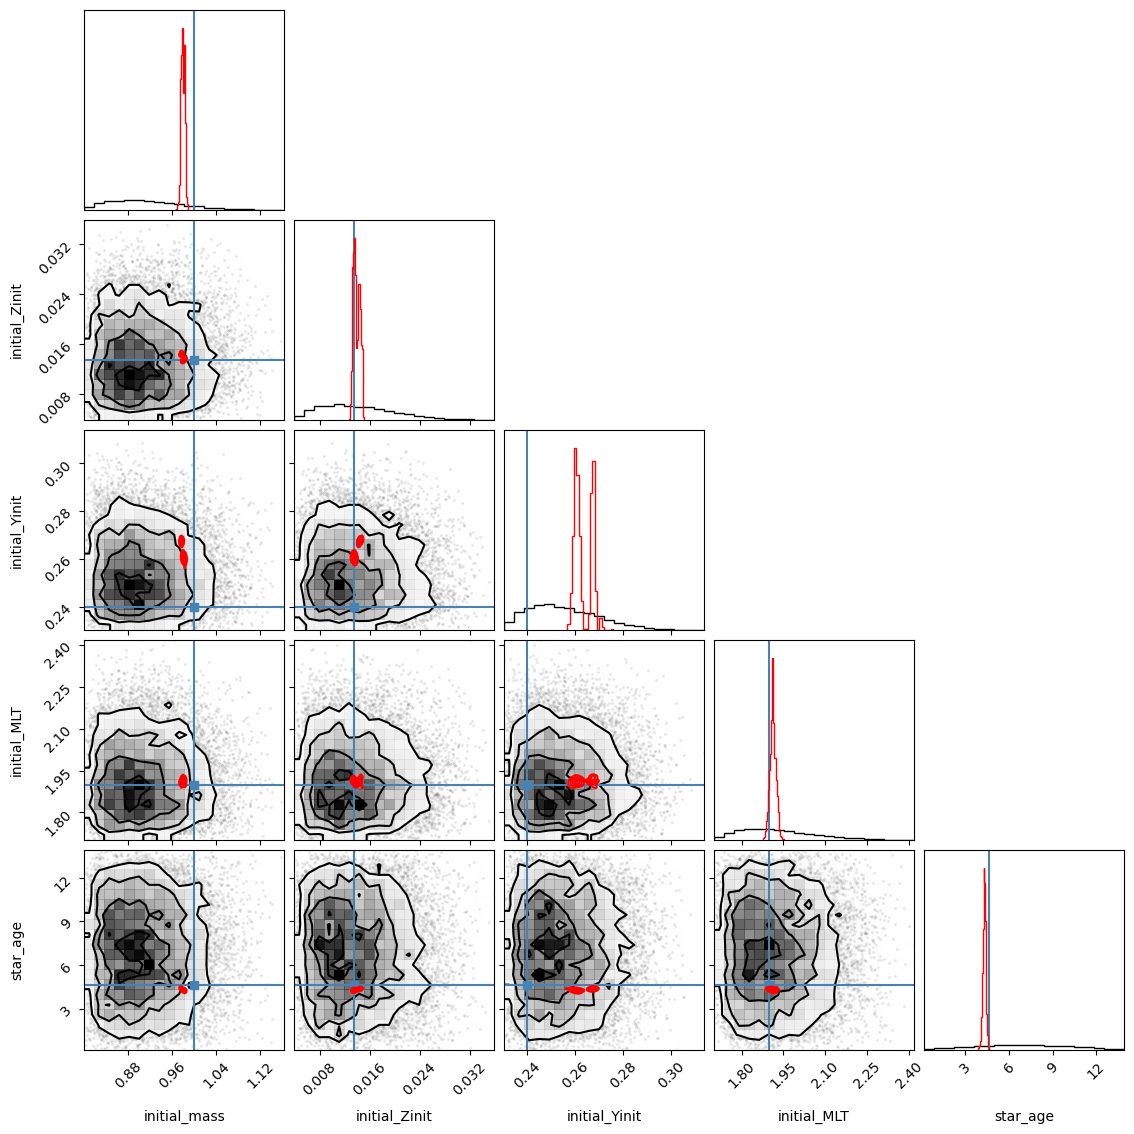

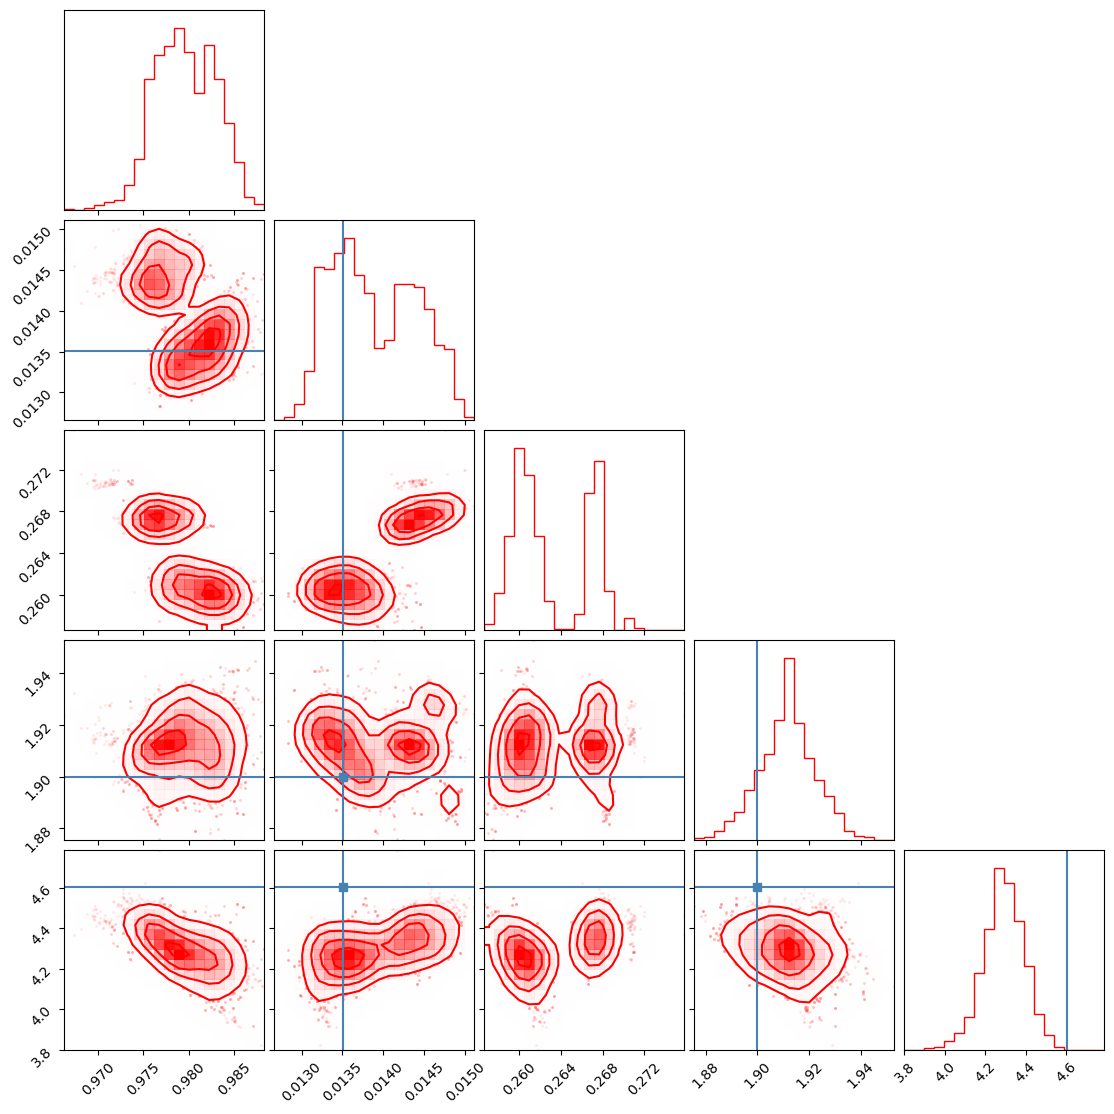

In [10]:
tic = time.time()
sampler = ns_old(priors=priors, observed_vals=hare_true.values[0], observed_unc = unc, pitchfork=pitchfork, logl_scale=1)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

figure = corner.corner(prior_samples, labels = inputs, truths = hare_inps.values[0], color='black',hist_kwargs={'density':True});
corner.corner(posterior, fig=figure, color='red',hist_kwargs={'density':True}, smooth=True);

figure = corner.corner(posterior, truths = hare_inps.values[0],color='red',hist_kwargs={'density':True}, smooth=True);